In [ ]:
from google.colab import files
files.upload()  # Sube tu archivo kaggle.json aquí

import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images
!unzip -q lung-and-colon-cancer-histopathological-images.zip -d lung_colon_dataset


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
 97% 1.71G/1.76G [00:04<00:00, 153MB/s] 
100% 1.76G/1.76G [00:04<00:00, 417MB/s]


In [ ]:
import shutil

colon_path = 'lung_colon_dataset/lung_colon_image_set/colon_image_sets'
lung_path = 'lung_colon_dataset/lung_colon_image_set/lung_image_sets'
unificado_path = 'lung_colon_dataset/unificado'

os.makedirs(unificado_path, exist_ok=True)

for subdir in [ lung_path]:
    for clase in os.listdir(subdir):
        origen = os.path.join(subdir, clase)
        destino = os.path.join(unificado_path, clase)
        os.makedirs(destino, exist_ok=True)
        for archivo in os.listdir(origen):
            src = os.path.join(origen, archivo)
            dst = os.path.join(destino, archivo)
            if os.path.isfile(src):
                shutil.copyfile(src, dst)

print("✅ Dataset unificado en:", unificado_path)


✅ Dataset unificado en: lung_colon_dataset/unificado


In [ ]:
import random

base_dir = 'lung_colon_dataset/unificado'
data_dir = 'lung_colon_dataset/organized'

# Crear carpetas destino
for split in ['train', 'val', 'test']:
    for clase in os.listdir(base_dir):
        os.makedirs(os.path.join(data_dir, split, clase), exist_ok=True)

# División
train_split = 0.7
val_split = 0.15

for clase in os.listdir(base_dir):
    img_list = [
        img for img in os.listdir(os.path.join(base_dir, clase))
        if os.path.isfile(os.path.join(base_dir, clase, img))
    ]
    random.shuffle(img_list)
    total = len(img_list)
    train_end = int(total * train_split)
    val_end = int(total * (train_split + val_split))

    for i, img in enumerate(img_list):
        src = os.path.join(base_dir, clase, img)

        if i < train_end:
            dst = os.path.join(data_dir, 'train', clase, img)
        elif i < val_end:
            dst = os.path.join(data_dir, 'val', clase, img)
        else:
            dst = os.path.join(data_dir, 'test', clase, img)

        shutil.copyfile(src, dst)

print("✅ Imágenes organizadas en train, val y test.")


✅ Imágenes organizadas en train, val y test.


In [ ]:
from collections import defaultdict

conteo = defaultdict(lambda: defaultdict(int))
for split in ['train', 'val', 'test']:
    split_path = os.path.join(data_dir, split)
    for clase in os.listdir(split_path):
        clase_path = os.path.join(split_path, clase)
        conteo[split][clase] = len([
            f for f in os.listdir(clase_path)
            if os.path.isfile(os.path.join(clase_path, f))
        ])

# Mostrar resumen
for split in ['train', 'val', 'test']:
    print(f"\n {split.upper()} SET:")
    total = 0
    for clase, cantidad in conteo[split].items():
        print(f"  - {clase}: {cantidad} imágenes")
        total += cantidad
    print(f"  🔹 Total en {split}: {total} imágenes")



 TRAIN SET:
  - lung_scc: 3500 imágenes
  - lung_aca: 3500 imágenes
  - lung_n: 3500 imágenes
  🔹 Total en train: 10500 imágenes

 VAL SET:
  - lung_scc: 750 imágenes
  - lung_aca: 750 imágenes
  - lung_n: 750 imágenes
  🔹 Total en val: 2250 imágenes

 TEST SET:
  - lung_scc: 750 imágenes
  - lung_aca: 750 imágenes
  - lung_n: 750 imágenes
  🔹 Total en test: 2250 imágenes


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Aumentos para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
)

# Validación y test solo normalización
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Ruta de datos
data_dir = 'lung_colon_dataset/organized'

train_gen = train_datagen.flow_from_directory(
    directory=os.path.join(data_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    directory=os.path.join(data_dir, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    directory=os.path.join(data_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Ver clases
print("Clases:", train_gen.class_indices)


Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Clases: {'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Cargar ResNet50 sin la parte final (include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Congelar todas excepto las últimas 60 capas del modelo base
for layer in base_model.layers[:-60]:
    layer.trainable = False

# 3. Agregar la "cabeza" personalizada al modelo
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)                      # Ayuda a evitar sobreajuste
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # 3 clases: lung_aca, lung_n, lung_scc

# 4. Construir el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compilar con un learning rate muy bajo para proteger pesos preentrenados
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 6. Mostrar resumen del modelo
model.summary()

# 7. EarlyStopping para prevenir sobreentrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 8. Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,                  # Hasta 30 épocas debido al tamaño del dataset
    callbacks=[early_stop]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 18,331,907 (69.93 MB)

 Non-trainable params: 5,518,464 (21.05 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 182s 462ms/step - accuracy: 0.6147 - loss: 0.7967 - val_accuracy: 0.3596 - val_loss: 2.3173
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 133s 402ms/step - accuracy: 0.8144 - loss: 0.4220 - val_accuracy: 0.6369 - val_loss: 0.8286
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 133s 405ms/step - accuracy: 0.8506 - loss: 0.3571 - val_accuracy: 0.8489 - val_loss: 0.3372
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 135s 410ms/step - accuracy: 0.8504 - loss: 0.3525 - val_accuracy: 0.3351 - val_loss: 4.2991
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 135s 409ms/step - accuracy: 0.8717 - loss: 0.3043 - val_accuracy: 0.8053 - val_loss: 0.5133
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 135s 409ms/step - accuracy: 0.8843 - loss: 0.2880 - val_accuracy: 0.5316 - val_loss: 1.7024
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 134s 405ms/step - accuracy: 0.8893 - loss: 0.2652 - val_accuracy: 0.8862 - val_loss: 0.2762
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 132s 402ms/step - accuracy: 0.8811 -

71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step
[[673  57  20]
 [  1 749   0]
 [198   2 550]]
              precision    recall  f1-score   support

    lung_aca       0.77      0.90      0.83       750
      lung_n       0.93      1.00      0.96       750
    lung_scc       0.96      0.73      0.83       750

    accuracy                           0.88      2250
   macro avg       0.89      0.88      0.87      2250
weighted avg       0.89      0.88      0.87      2250



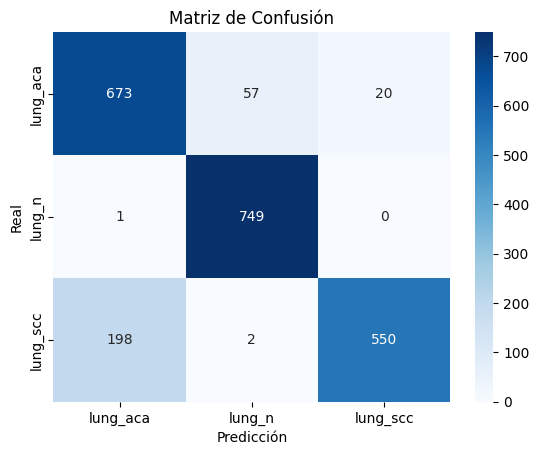

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Generar predicciones en el set de prueba
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

# Reporte detallado de clasificación
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

# Visualización gráfica
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()


(7, 7, 3, 64)


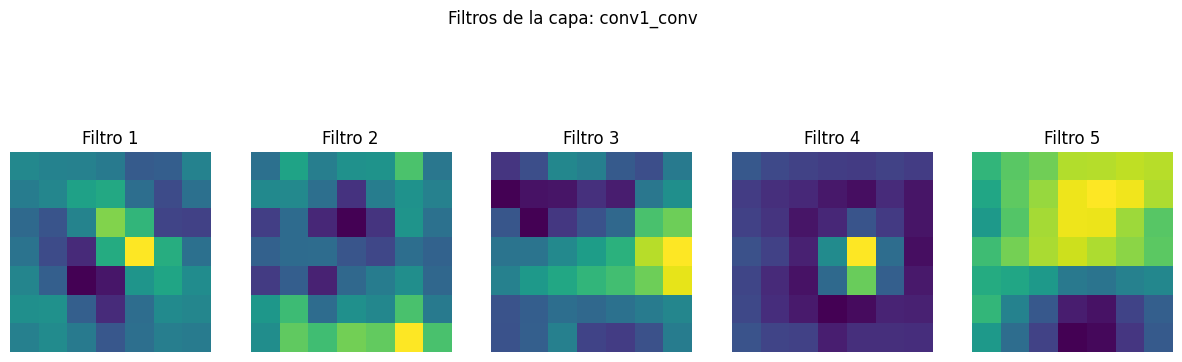

In [ ]:
# Visualizar pesos de una capa convolucional específica
import matplotlib.pyplot as plt

# Elegir una capa convolucional intermedia del modelo base
layer_name = 'conv1_conv'  # Ejemplo de capa inicial (puedes cambiarla)
layer = model.get_layer(layer_name)
weights, biases = layer.get_weights()

print(weights.shape)

# Mostrar algunos filtros
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    ax = axes[i]
    filter_weights = weights[:, :, :, i]
    filter_min, filter_max = filter_weights.min(), filter_weights.max()
    filter_weights = (filter_weights - filter_min) / (filter_max - filter_min)

    ax.imshow(filter_weights[:, :, 0], cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Filtro {i+1}')

plt.suptitle(f'Filtros de la capa: {layer_name}')
plt.show()
